# **Natural Language Processing with Disaster Tweets**

---

# **Project Overview**

This project addresses the Natural Language Processing with Disaster Tweets Kaggle competition, which challenges participants to build a machine learning model that can accurately classify whether a tweet is about a real disaster or not. This is a binary classification problem with significant practical applications for emergency response and social media monitoring.

-----

# **Problem Statement**

In today's digital age, social media platforms like Twitter have become important sources of real-time information during emergencies. However, it can be difficult to distinguish between tweets that report actual disasters and those that use disaster-related language metaphorically or humorously. This project aims to solve this classification problem using advanced natural language processing techniques.

---

# **Approach**

The solution implements a sophisticated NLP pipeline with the following components:

1. **Data Analysis & Exploration:** Comprehensive analysis of tweet distribution, text length patterns, keyword frequency, and hashtag usage
2. **Text Preprocessing:** Specialized cleaning techniques for social media text including:
   · URL removal
   
   · Handle/@mention removal
   
   · Hashtag processing
   
   · Text normalization
   
4. **Transformer-Based Modeling:** Implementation of a BERT-based classifier fine-tuned on the tweet dataset
5. **Evaluation & Interpretation:** Detailed model performance analysis with confidence scoring and error analysis

---

# **Technical Stack**

· Python with PyTorch for deep learning

· Hugging Face Transformers for BERT implementation

· Scikit-learn for evaluation metrics

· Pandas & NumPy for data manipulation

· Matplotlib & Seaborn for visualization

---
# **Key Features**

· Handles the unique challenges of social media text (informal language, emojis, hashtags)

· Implements state-of-the-art transformer architecture

· Provides detailed model interpretability and confidence scoring

· Includes comprehensive error analysis

---

This project demonstrates the application of cutting-edge NLP techniques to a real-world problem with potential humanitarian applications, showcasing how machine learning can be used to filter signal from noise in critical situations.

# **Installations**

In [1]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nv

# **Import Libraries**

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    get_linear_schedule_with_warmup
)
# Use PyTorch's AdamW instead of transformers'
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# **Load Data**

Training data shape: (7613, 5)
Test data shape: (3263, 4)


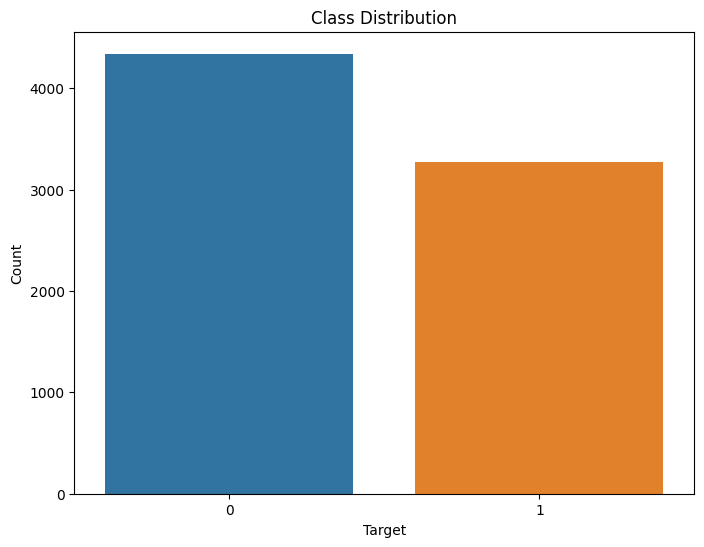

In [3]:
# Load data
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
submission_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Display class distribution
class_distribution = train_df['target'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# **Exploratory Data Analysis**

In [4]:
# Import required libraries for data analysis

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# Set style for plots
plt.style.use('ggplot')
sns.set_palette("Set2")

# Load the data
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Display basic information about the dataset
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nTraining Data Columns:", train_df.columns.tolist())
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())

# Display first few rows
print("\nFirst 5 rows of training data:")
display(train_df.head())

Training Data Shape: (7613, 5)
Test Data Shape: (3263, 4)

Training Data Columns: ['id', 'keyword', 'location', 'text', 'target']

Missing Values in Training Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test Data:
id             0
keyword       26
location    1105
text           0
dtype: int64

First 5 rows of training data:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# **Target distribution analysis**


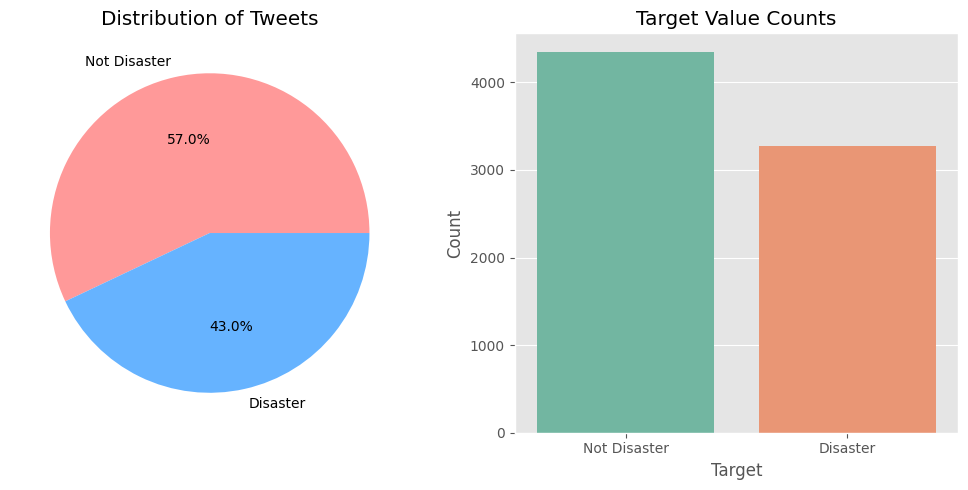

Non-disaster tweets: 4342 (57.03%)
Disaster tweets: 3271 (42.97%)


In [5]:
target_counts = train_df['target'].value_counts()
plt.figure(figsize=(10, 5))

# Pie chart
plt.subplot(1, 2, 1)
plt.pie(target_counts.values, labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Tweets')

# Bar plot
plt.subplot(1, 2, 2)
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Target Value Counts')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

# Print exact counts
print(f"Non-disaster tweets: {target_counts[0]} ({target_counts[0]/len(train_df)*100:.2f}%)")
print(f"Disaster tweets: {target_counts[1]} ({target_counts[1]/len(train_df)*100:.2f}%)")

# **Text length analysis**


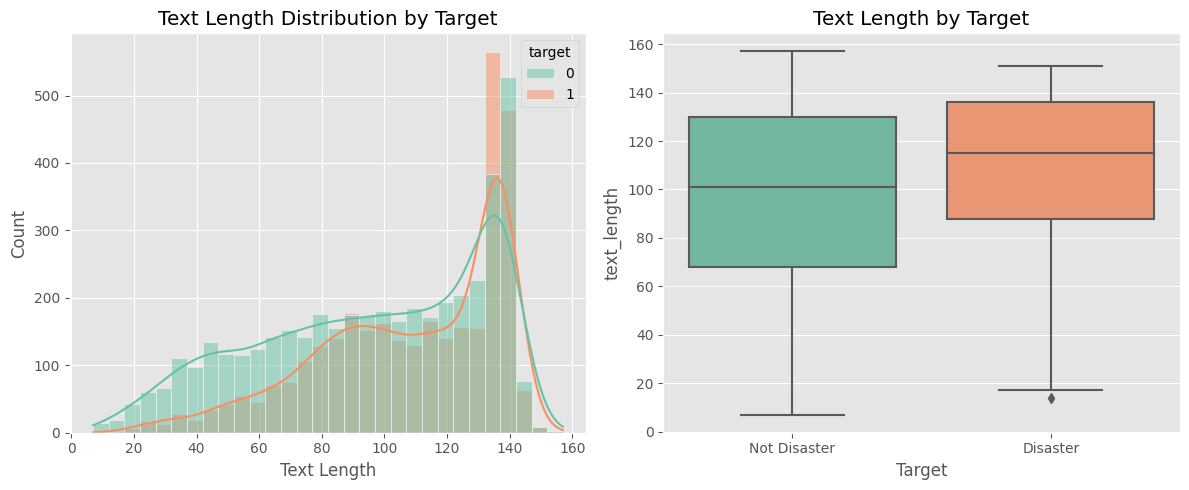

Average text length for disaster tweets: 108.11 characters
Average text length for non-disaster tweets: 95.71 characters


In [6]:
train_df['text_length'] = train_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='text_length', hue='target', bins=30, kde=True)
plt.title('Text Length Distribution by Target')
plt.xlabel('Text Length')

plt.subplot(1, 2, 2)
sns.boxplot(data=train_df, x='target', y='text_length')
plt.title('Text Length by Target')
plt.xlabel('Target')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

# Average text length
avg_length_disaster = train_df[train_df['target'] == 1]['text_length'].mean()
avg_length_non_disaster = train_df[train_df['target'] == 0]['text_length'].mean()
print(f"Average text length for disaster tweets: {avg_length_disaster:.2f} characters")
print(f"Average text length for non-disaster tweets: {avg_length_non_disaster:.2f} characters")

# **Keyword analysis**


Number of unique keywords: 221
Top 10 keywords:
keyword
fatalities     45
armageddon     42
deluge         42
harm           41
damage         41
sinking        41
body%20bags    41
siren          40
windstorm      40
twister        40
Name: count, dtype: int64


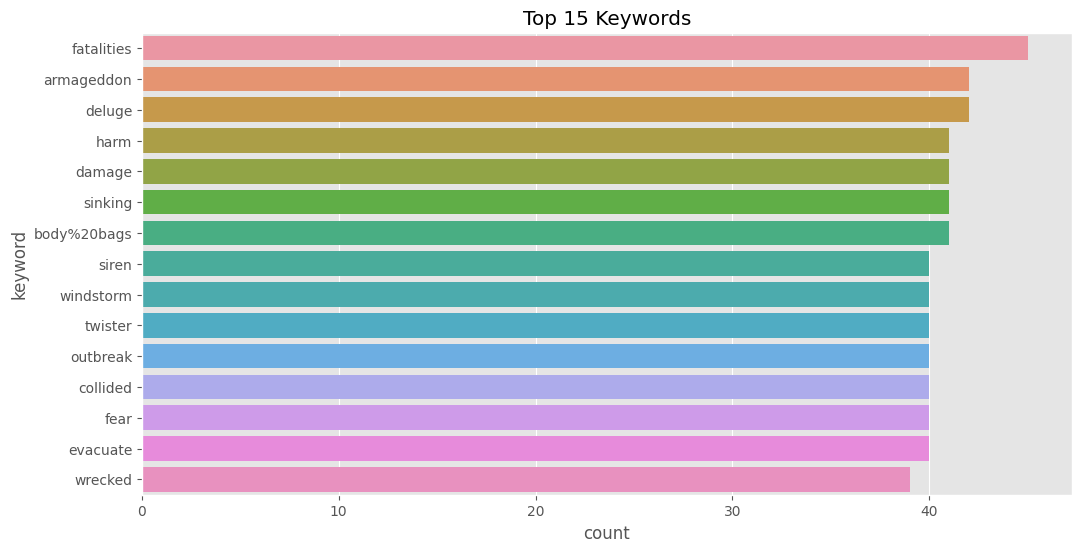


Keywords with highest disaster rate:
keyword
wreckage             1.000000
debris               1.000000
derailment           1.000000
outbreak             0.975000
oil%20spill          0.973684
typhoon              0.973684
suicide%20bombing    0.969697
suicide%20bomber     0.967742
bombing              0.931034
suicide%20bomb       0.914286
Name: target, dtype: float64


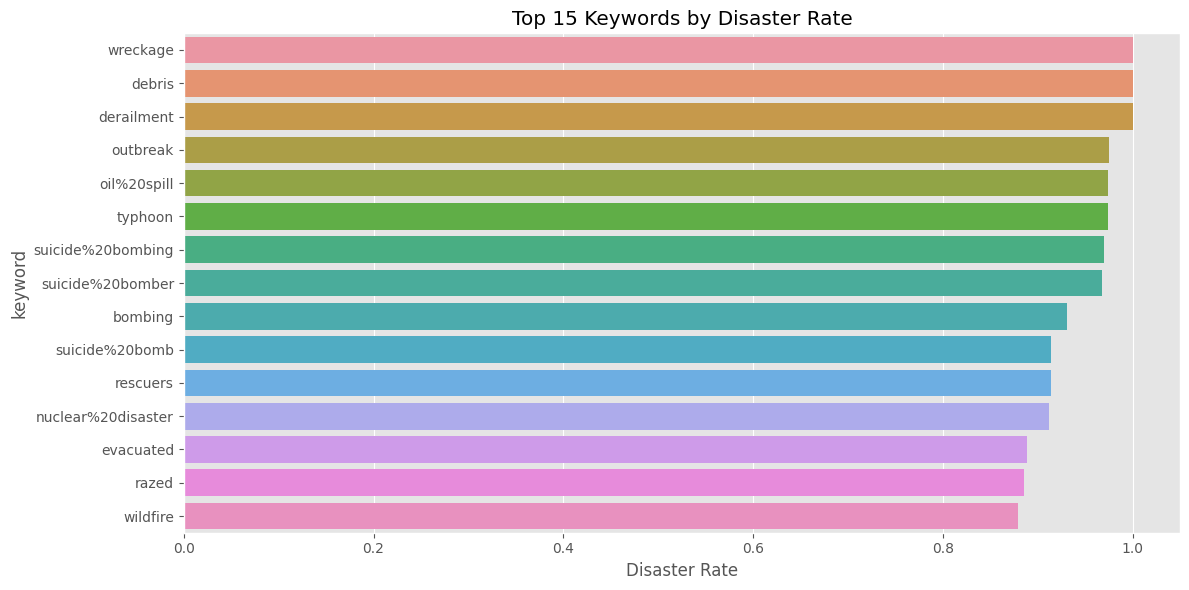

In [7]:
print("Number of unique keywords:", train_df['keyword'].nunique())
print("Top 10 keywords:")
top_keywords = train_df['keyword'].value_counts().head(10)
print(top_keywords)

plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, y='keyword', 
              order=train_df['keyword'].value_counts().index[:15])
plt.title('Top 15 Keywords')
plt.show()

# Check which keywords are most associated with disasters
keyword_disaster_rate = train_df.groupby('keyword')['target'].mean().sort_values(ascending=False)
print("\nKeywords with highest disaster rate:")
print(keyword_disaster_rate.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x=keyword_disaster_rate.head(15).values, y=keyword_disaster_rate.head(15).index)
plt.title('Top 15 Keywords by Disaster Rate')
plt.xlabel('Disaster Rate')
plt.tight_layout()
plt.show()

# **location analysis**

Number of unique locations: 3341
Top 10 locations:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


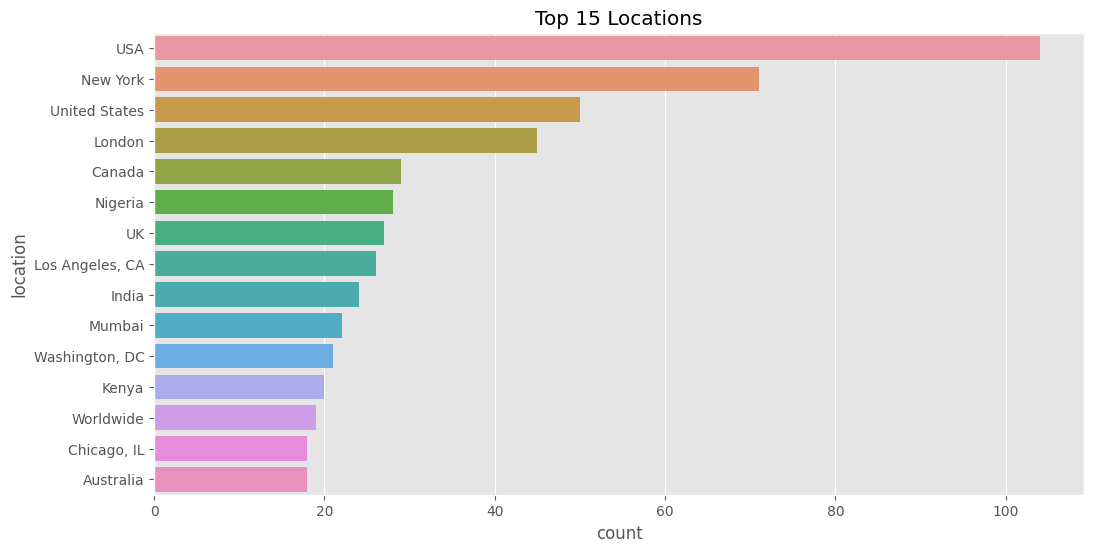

In [8]:
if 'location' in train_df.columns:
    print("Number of unique locations:", train_df['location'].nunique())
    print("Top 10 locations:")
    top_locations = train_df['location'].value_counts().head(10)
    print(top_locations)
    
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_df, y='location', 
                  order=train_df['location'].value_counts().index[:15])
    plt.title('Top 15 Locations')
    plt.show()

# **Word cloud visualization**


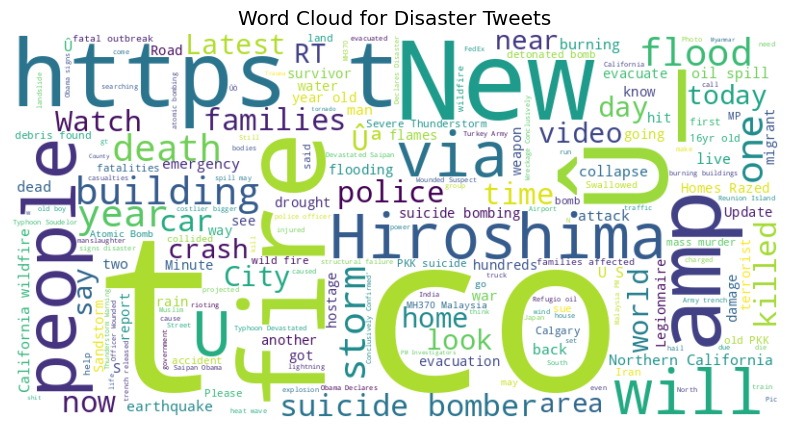

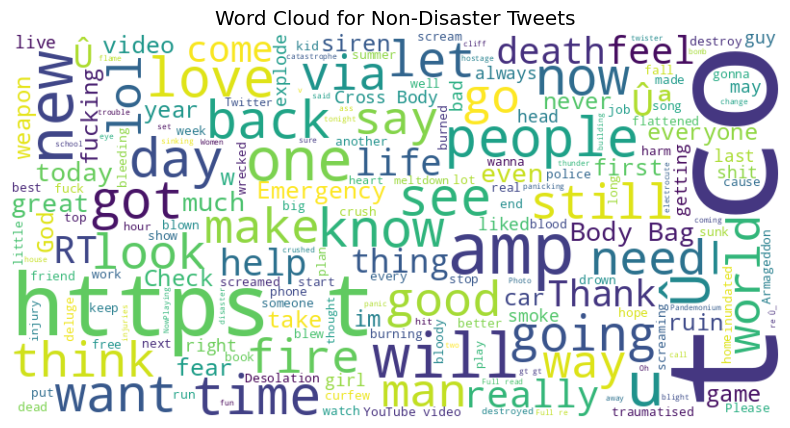

In [9]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis'
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for disaster and non-disaster tweets
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'].tolist())
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'].tolist())

generate_wordcloud(disaster_text, 'Word Cloud for Disaster Tweets')
generate_wordcloud(non_disaster_text, 'Word Cloud for Non-Disaster Tweets')

# **Hashtag analysis**


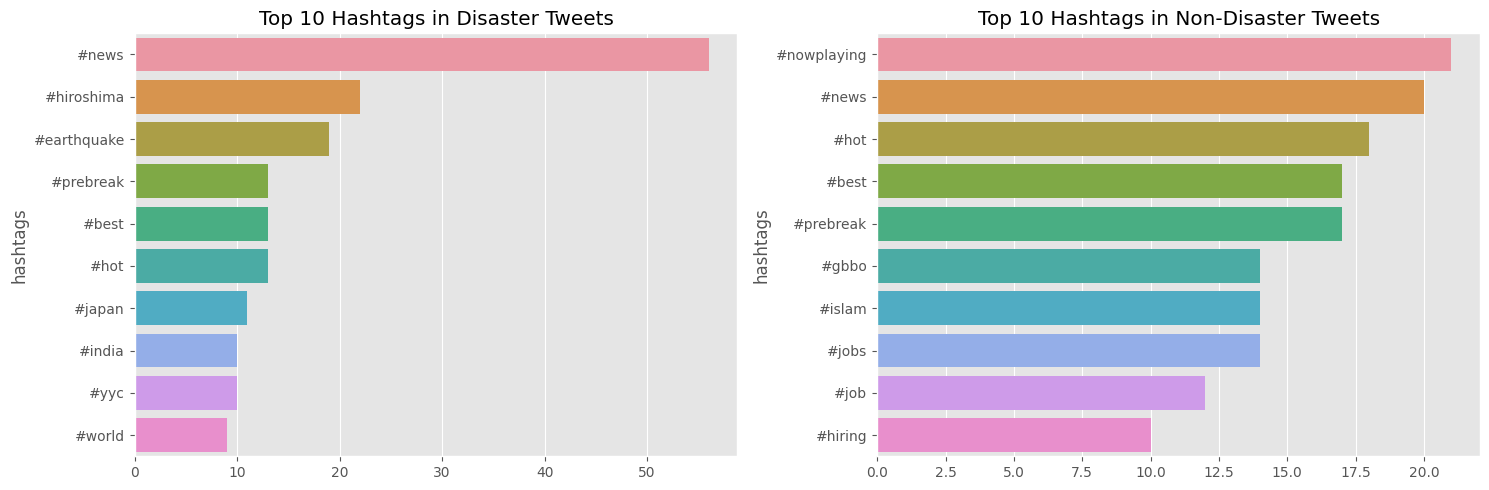

In [10]:
def extract_hashtags(text):
    return re.findall(r'#\w+', text.lower())

train_df['hashtags'] = train_df['text'].apply(extract_hashtags)
disaster_hashtags = train_df[train_df['target'] == 1]['hashtags'].explode().value_counts().head(10)
non_disaster_hashtags = train_df[train_df['target'] == 0]['hashtags'].explode().value_counts().head(10)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=disaster_hashtags.values, y=disaster_hashtags.index)
plt.title('Top 10 Hashtags in Disaster Tweets')

plt.subplot(1, 2, 2)
sns.barplot(x=non_disaster_hashtags.values, y=non_disaster_hashtags.index)
plt.title('Top 10 Hashtags in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

# **Preprocessing**


In [11]:
def preprocess_text(text):
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+', '', text)
        # Remove user mentions
        text = re.sub(r'@\w+', '', text)
        # Remove special characters except hashtags
        text = re.sub(r'[^a-zA-Z\s#]', '', text)
        return text.strip()
    return ""

# Apply preprocessing
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_df['cleaned_text'].values,
    train_df['target'].values,
    test_size=0.2,
    random_state=42,
    stratify=train_df['target'].values
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 6090
Validation samples: 1523


# **Configuration and tokenizer**


In [12]:
MODEL_NAME = 'bert-base-uncased'  # Using BERT which should be available on Kaggle
MAX_LEN = 128
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 3

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#  **Dataset class**


In [13]:
class TweetDataset(Dataset):
    def __init__(self, texts, targets=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.targets is not None:
            output['targets'] = torch.tensor(self.targets[idx], dtype=torch.long)
            
        return output

# Create data loaders
train_dataset = TweetDataset(
    texts=X_train,
    targets=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = TweetDataset(
    texts=X_val,
    targets=y_val,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# **Model Architectue**

In [14]:
# BERT Classifier
class BERTClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2, dropout_rate=0.2):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

# Initialize model
model = BERTClassifier(MODEL_NAME)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Loss function
criterion = nn.CrossEntropyLoss()

2025-09-08 07:05:30.871797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757315131.030991      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757315131.077485      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# **Training function**


In [15]:
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct_predictions = 0
    
    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets)
        total_loss += loss.item()
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, accuracy

# Validation function
def eval_epoch(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, targets)
            
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets)
            total_loss += loss.item()
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_targets

# **Training loop**


In [16]:
best_accuracy = 0
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 50)
    
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, scheduler
    )
    
    val_loss, val_acc, val_f1, val_preds, val_targets = eval_epoch(
        model, val_loader, criterion, device
    )
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
    
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print('Model saved!')


Epoch 1/3
--------------------------------------------------


Validation: 100%|██████████| 96/96 [00:05<00:00, 17.75it/s]


Train Loss: 0.4652, Train Acc: 0.7934
Val Loss: 0.3779, Val Acc: 0.8549, Val F1: 0.8531
Model saved!

Epoch 2/3
--------------------------------------------------


Validation: 100%|██████████| 96/96 [00:05<00:00, 17.80it/s]


Train Loss: 0.3445, Train Acc: 0.8642
Val Loss: 0.3878, Val Acc: 0.8496, Val F1: 0.8492

Epoch 3/3
--------------------------------------------------


Validation: 100%|██████████| 96/96 [00:05<00:00, 17.70it/s]

Train Loss: 0.2675, Train Acc: 0.9023
Val Loss: 0.4610, Val Acc: 0.8424, Val F1: 0.8417


# **Evaluation and Visualization**

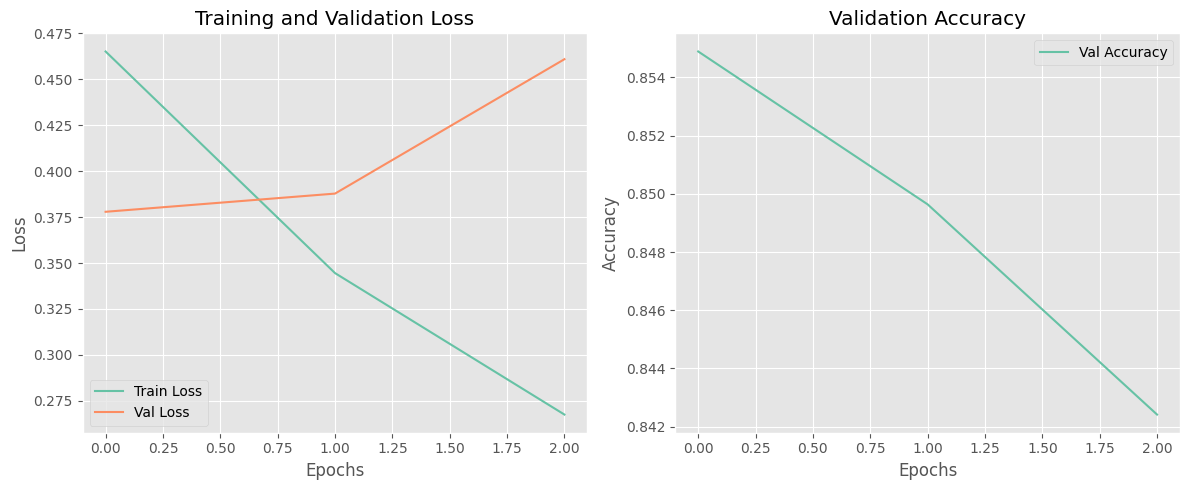

Validation: 100%|██████████| 96/96 [00:05<00:00, 17.60it/s]



Final Validation Results:
Accuracy: 0.8549
F1 Score: 0.8531

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       869
           1       0.88      0.76      0.82       654

    accuracy                           0.85      1523
   macro avg       0.86      0.84      0.85      1523
weighted avg       0.86      0.85      0.85      1523



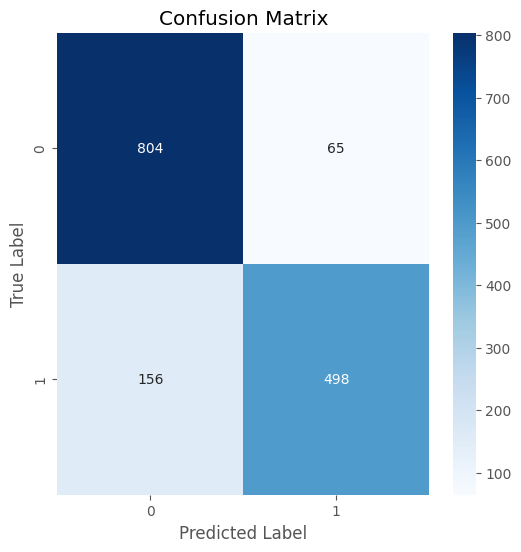

In [17]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Detailed evaluation
val_loss, val_acc, val_f1, val_preds, val_targets = eval_epoch(
    model, val_loader, criterion, device
)

print(f'\nFinal Validation Results:')
print(f'Accuracy: {val_acc:.4f}')
print(f'F1 Score: {val_f1:.4f}')
print('\nClassification Report:')
print(classification_report(val_targets, val_preds))

# Confusion Matrix
cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **Prediction Examples and Results Display**

In [18]:
if 'cleaned_text' not in test_df.columns:
    test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

# Create a function to display sample predictions with confidence
def display_predictions(model, tokenizer, device, sample_texts, sample_true=None):
    model.eval()
    results = []
    
    for i, text in enumerate(sample_texts):
        # Tokenize the text
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, prediction = torch.max(probabilities, dim=1)
            
        # Interpret results
        pred_label = "Disaster" if prediction.item() == 1 else "Not Disaster"
        confidence_percent = confidence.item() * 100
        
        result = {
            "Text": text,
            "Prediction": pred_label,
            "Confidence": f"{confidence_percent:.2f}%"
        }
        
        if sample_true is not None:
            true_label = "Disaster" if sample_true[i] == 1 else "Not Disaster"
            result["True Label"] = true_label
            result["Correct"] = "✓" if pred_label == true_label else "✗"
            
        results.append(result)
    
    return pd.DataFrame(results)

# Select some examples from the validation set for demonstration
sample_indices = [10, 25, 50, 75, 100]  # Random indices
sample_texts = X_val[sample_indices]
sample_true = y_val[sample_indices]

# Display predictions on validation samples
print("Validation Set Predictions:")
val_samples_df = display_predictions(model, tokenizer, device, sample_texts, sample_true)
display(val_samples_df)

# Select some examples from the test set for demonstration
test_sample_indices = [0, 5, 15, 25, 35]
test_sample_texts = test_df['cleaned_text'].iloc[test_sample_indices].values

print("\nTest Set Predictions:")
test_samples_df = display_predictions(model, tokenizer, device, test_sample_texts)
display(test_samples_df)

Validation Set Predictions:


,Text,Prediction,Confidence,True Label,Correct
0,rip the world its burning,Not Disaster,93.05%,Not Disaster,✓
1,On this day in Appetite For Destruction goes ...,Not Disaster,93.43%,Not Disaster,✓
2,I may have gotten a little too exited over my ...,Not Disaster,92.14%,Not Disaster,✓
3,Wildfire Burns On California Us China Economic...,Disaster,98.71%,Disaster,✓
4,Train derailment In Patna no news of any casua...,Disaster,98.64%,Disaster,✓



Test Set Predictions:


,Text,Prediction,Confidence
0,Just happened a terrible car crash,Disaster,91.70%
1,Were shakingIts an earthquake,Disaster,94.91%
2,Birmingham Wholesale Market is ablaze BBC News...,Disaster,97.63%
3,the bins in front of the field by my house wer...,Disaster,83.87%
4,If you pretend to feel a certain way the feeli...,Not Disaster,95.21%


# **Prediction and Submission**

In [19]:
# Prepare test dataset
test_dataset = TweetDataset(
    texts=test_df['cleaned_text'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# Make predictions on test set
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Predicting'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    
    return predictions

test_predictions = predict(model, test_loader, device)

# Create submission file
submission_df['target'] = test_predictions
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
print(f"Positive predictions: {sum(test_predictions)}/{len(test_predictions)}")

# Display sample predictions
sample_test = test_df.copy()
sample_test['predicted_target'] = test_predictions
print(sample_test[['text', 'predicted_target']].head(10))

Predicting:   0%|          | 0/204 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Predicting: 100%|██████████| 204/204 [00:11<00:00, 17.85it/s]


Submission file created successfully!
Positive predictions: 1158/3263
                                                text  predicted_target
0                 Just happened a terrible car crash                 1
1  Heard about #earthquake is different cities, s...                 1
2  there is a forest fire at spot pond, geese are...                 1
3           Apocalypse lighting. #Spokane #wildfires                 1
4      Typhoon Soudelor kills 28 in China and Taiwan                 1
5                 We're shaking...It's an earthquake                 1
6  They'd probably still show more life than Arse...                 0
7                                  Hey! How are you?                 0
8                                   What a nice hat?                 0
9                                          Fuck off!                 0


In [20]:
# Final submission summary
print("=== FINAL SUBMISSION SUMMARY ===")
print(f"Model: {MODEL_NAME}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print(f"Test Predictions - Disaster: {sum(test_predictions)}")
print(f"Test Predictions - Not Disaster: {len(test_predictions) - sum(test_predictions)}")

# Show the first few rows of the submission file
print("\nFirst 5 rows of submission file:")
display(submission_df.head())

# Save the final submission with a descriptive name
submission_name = f"submission_{MODEL_NAME.replace('/', '')}_acc{val_acc:.4f}.csv"
submission_df.to_csv(submission_name, index=False)
print(f"\nSubmission saved as: {submission_name}")

=== FINAL SUBMISSION SUMMARY ===
Model: bert-base-uncased
Validation Accuracy: 0.8549
Validation F1 Score: 0.8531
Test Predictions - Disaster: 1158
Test Predictions - Not Disaster: 2105

First 5 rows of submission file:


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1



Submission saved as: submission_bert-base-uncased_acc0.8549.csv


# **Additional analysis: Show the most confident predictions**


In [21]:
def get_most_confident_predictions(model, tokenizer, device, texts, predictions, n=5, disaster=True):
    model.eval()
    confidences = []
    
    for i, text in enumerate(texts):
        if (disaster and predictions[i] == 1) or (not disaster and predictions[i] == 0):
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=MAX_LEN,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                probabilities = torch.softmax(outputs, dim=1)
                confidence, _ = torch.max(probabilities, dim=1)
                
            confidences.append((i, text, confidence.item()))
    
    # Sort by confidence and get top n
    confidences.sort(key=lambda x: x[2], reverse=True)
    return confidences[:n]

# Get most confident disaster predictions
top_disaster = get_most_confident_predictions(model, tokenizer, device, 
                                             test_df['cleaned_text'].values, 
                                             test_predictions, n=3, disaster=True)

print("Most Confident Disaster Predictions:")
for idx, text, confidence in top_disaster:
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"Text: {text}")
    print("-" * 80)

# Get most confident non-disaster predictions
top_non_disaster = get_most_confident_predictions(model, tokenizer, device, 
                                                 test_df['cleaned_text'].values, 
                                                 test_predictions, n=3, disaster=False)

print("\nMost Confident Non-Disaster Predictions:")
for idx, text, confidence in top_non_disaster:
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"Text: {text}")
    print("-" * 80)

Most Confident Disaster Predictions:
Confidence: 98.98%
Text: Refugio oil spill may have been costlier bigger than projected A Plains All American Pipeline oil spill  #MLB
--------------------------------------------------------------------------------
Confidence: 98.97%
Text: #EPAO MARSAC reports on Manipur flood Heavy incessant rains in Manipur have led to inundation causin  #MANIPUR
--------------------------------------------------------------------------------
Confidence: 98.94%
Text: Officials Alabama home quarantined over possible Ebola case
--------------------------------------------------------------------------------

Most Confident Non-Disaster Predictions:
Confidence: 96.91%
Text: So if you secretly have a crush on me and can sing lmk lmfao
--------------------------------------------------------------------------------
Confidence: 96.70%
Text: If youve got it flaunt it 
Unless youve got an awful lot of itthen please dont
---------------------------------------------------